In [74]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from bgan_nogen import BGANNG, FixedSizeDataset
from datasets import DigitsDataset

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [86]:
data = DigitsDataset()
trainloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

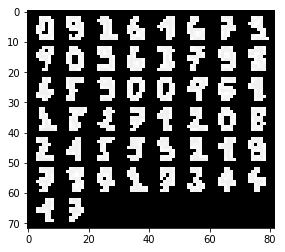

In [89]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images = data.inverse_transform(dataiter.next())
images = torch.from_numpy(images)
# images = images.view(-1, 1, 8, 8)

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN-NG

In [90]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [102]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, shape, num_samples):
        super(GeneratorNetwork, self).__init__()
        self.build_net(shape, num_samples)
        self.output_dim = shape
    
    def build_net(self, shape, num_samples):
        z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, K, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, K, h_dim)
        self.x_dim = x_dim
        self.K = K
    
    def build_net(self, x_dim, K, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, K),
            nn.Softmax()
        )
    
    def forward(self, input):
        # TODO: understand parallelism?
        output = self.network(input.view(-1, 64))
        return output
    
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [103]:
batch_size = 50

In [176]:
prior = FactorizedNormalPrior(std=5.)
disc = DiscriminatorNetwork(x_dim=64, K=2, h_dim=100)
gen = GeneratorNetwork([64], 1)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-6, num_data=len(data), disc_lr=1e-5)
samples = []

In [ ]:
old_samples = None
if isinstance(samples, np.ndarray):
    old_samples = np.copy(samples)
    samples = []
for epoch in range(10000):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
        
        if not i%100:
            bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%1:
        samples.append(np.copy(gen.z_v.data.numpy()))
    if not epoch%100:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
if old_samples is not None:
    samples = np.vstack([old_samples, np.vstack(samples)])
else:
    samples = np.array(samples)

0
0.000401629
-1.00009e-12
100
0.000199483
2.38418e-07
200
0.00121547
-1.00009e-12
300
0.000245281
-1.00009e-12
400
0.000236365
-1.00009e-12
500
0.000415865
-1.00009e-12
600
0.000386752
-1.00009e-12
700
0.00069156
3.57627e-07
800
0.000305992
-1.00009e-12
900
0.000165901
0.000166192
1000
0.000163128
1.32919e-05
1100
0.000289277
-1.00009e-12
1200
0.000154147
-1.00009e-12
1300
0.00854668
4.76836e-07
1400
0.000114482
2.33653e-05
1500
0.000407858
-1.00009e-12
1600
0.000411322
-1.00009e-12
1700
0.000291018
7.45061e-06
1800
0.00572841
-1.00009e-12
1900
0.00592744
-1.00009e-12
2000
0.000158807
1.85372e-05
2100
9.52318e-05
-1.00009e-12
2200
0.000103579
4.23194e-06
2300
9.30289e-05
1.19208e-07
2400
8.22373e-05
-1.00009e-12
2500
0.000151076
-1.00009e-12
2600
0.000132115
-1.00009e-12
2700
0.000270997
-1.00009e-12
2800
0.00059879
-1.00009e-12
2900
0.000402511
1.78813e-07
3000
0.000489744
0.00116494
3100
0.000161351
1.78813e-07
3200
0.00531531
0.00541799
3300
0.000356894
-1.00009e-12
3400
6.31675e-0

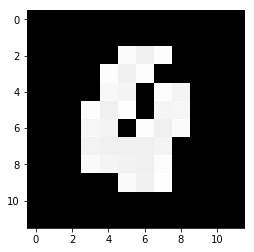

In [216]:
batch_samples_ = batch[:10]
batch_np = data.inverse_transform(batch_samples_)
imshow(torchvision.utils.make_grid(torch.from_numpy(batch_np)))

In [217]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)

In [218]:
indices = (np.linspace(0, 1, 20) * (len(fake_samples)-1)).astype(int)

In [219]:
# fake_samples_ = torch.from_numpy(fake_samples[indices]).view(-1, 1, 8, 8)
fake_samples_ = torch.from_numpy(fake_samples[-20:]).view(-1, 1, 8, 8)
fake_np = data.inverse_transform(fake_samples_)

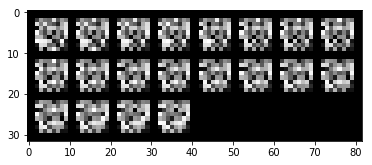

In [220]:
imshow(torchvision.utils.make_grid(torch.from_numpy(fake_np)))

In [221]:
sample_probs = disc(Variable(torch.from_numpy(fake_np)))[:, 0].data.numpy()

In [222]:
sample_probs

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [224]:
disc(Variable(batch))[:, 0]

Variable containing:
 0.9982
[torch.FloatTensor of size 1]